# Prosjekt 2 numdiff 

In [125]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rd
from scipy import integrate
from scipy.integrate import quad
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)
from scipy import interpolate

Set ut the subdivision ('triangulation') of space: Choose nodes $x_i$ and elements $K_k=(x_{k-1},x_{k})$. 

In [126]:
def create_x(M): #returns x-array with random steplengths from 0 to 1
    x_inner = rd.rand(M-2)
    x_bc = np.array([0,1])
    x = np.sort(np.concatenate((x_inner, x_bc)))
    return M, x 

In [127]:
#constants for stiffnessmatrix A
alpha = 1
b = 1
c = 4

Help function for the assembly process:

In [128]:
def loc2glob(k,phi_i): #lokal til global
    return k+phi_i          # Numbering k from 0

Phi vectors and function for Assemply process:

In [129]:
def f_1(x):
    u = x - x**2
    ux = 1- 2*x
    uxx = -2
    return -alpha * uxx + b * ux + c * u

def u_exact_1(x):
    return x-x**2

def f_2(x):
    u = np.sin(3*np.pi*x)
    ux = 3 * np.pi * np.cos(3 * np.pi * x)
    uxx = - (3 * np.pi)**2 *np.sin(3 * np.pi * x)
    return -alpha * uxx + b * ux + c * u

def u_exact_2(x):
    return np.sin(3*np.pi*x)

def phi_up(x, ximinus1, hi):
    return (x-ximinus1)/hi

def phi_down(x, xi, hi):
    return (xi-x)/hi

Functions to assemble A matrix and F matrix for different X vectors with corresponding length Mi

In [130]:
def create_A(Xk, Mi, T, H, Mk):
    
    #Set up elemental stiffness matrices:
    Ak_1 = np.array([[alpha, -alpha],[-alpha, alpha]])      #første ledd som skal deles på H[k]
    Ak_2 = np.array([[b/2, b/2],[-b/2, -b/2]])              #andre ledd som bare er en konstrant /ikke avhengig av H[k]
    Ak_3 = np.array([[c/3, c/6],[c/6, c/3]])                #tredje legg som skal ganges med H[k]
    
    A = np.zeros((Mi,Mi))

    for k in range(0, Mk):
        for phi_i in range(2):
            i = loc2glob(k,phi_i)
            for phi_j in range(2):
                j = loc2glob(k,phi_j)
                A[i,j] += (Ak_1[phi_i,phi_j]/H[k] + Ak_2[phi_i,phi_j] + Ak_3[phi_i,phi_j]*H[k])#A[i,j] += Ak[alpha,beta]/H[k]                                                       
    return A
    
def create_F(f_func, X, H, Mi):
    '''input:
    f_function 
    X: array of size Mi, x-axis points
    H: array of size Mi, step sizes'''
    F = np.zeros(Mi)
    
    #F0
    F[0] = integrate.quad(lambda x: f_func(x)*phi_down(x, X[1], H[0]), X[0], X[1])[0]

    #F_i = integral(f*phi_i)
    for i in range(1, len(H)):
        first_int = integrate.quad(lambda x: f_func(x) * phi_up(x, X[i-1], H[i-1]), X[i-1], X[i])[0]       #integrating from x_i-1 to xi
        second_int = integrate.quad(lambda x: f_func(x) * phi_down(x, X[i+1], H[i]), X[i], X[i+1])[0]    #integrating from xi to xi+1
        F[i] = first_int + second_int

    #FM
    F[-1] = integrate.quad(lambda x: f_func(x)*phi_up(x, X[-2], H[-1]), X[-2], X[-1])[0]
    
    return F

Solver for the linear system 
$AU = F$

In [131]:
def solver_FEM(Xk, f_func, create_f_func = create_F, new_solver = False):
    Mi = len(Xk)                     #Number of nodes
    T = np.ndarray.transpose(np.array([Xk[:-1],Xk[1:]])) # Set of elements/triangulation
    H = Xk[1:]-Xk[:-1]               #Element sizes
    Mk = Mi-1                        #Number of elements
    
    if new_solver:  #the new method
        F = create_f_func(Xk, Mi, H, 1/2, fv_w1_left_up, fv_w1_left_down, fv_w1_right_up, fv_w1_right_down)
    else:
        F = create_f_func(f_func, Xk, H, Mi)
        
    A = create_A(Xk, Mi, T, H, Mk)
    
    #solving for inner points:
    U_inner = np.linalg.solve(A[1:-1, 1:-1],F[1:-1])
    
    #Combining with boundary conditions u0 = 0 = u1
    U_total = np.zeros(len(U_inner)+2)
    U_total[1:-1] = U_inner
    
    return U_total
    

Function to plot:

In [132]:
def plot_solution(X, U, u_exact_func):
    plt.plot(X,U)
    plt.plot(X, u_exact_func(X),'o')
    plt.legend(['Numerical','Exact'])
    plt.xlabel('x');

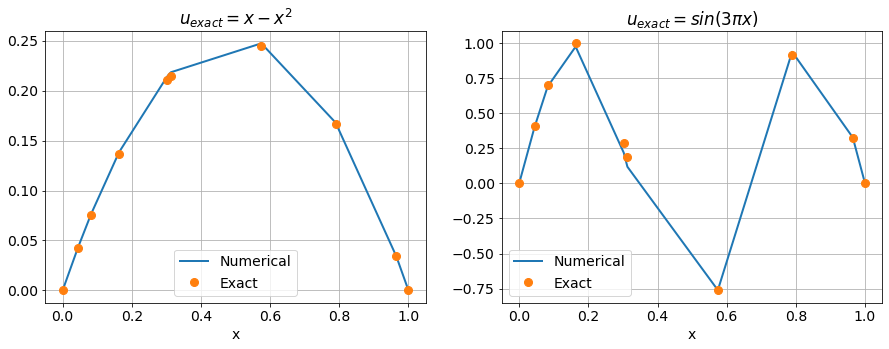

In [133]:
Mi, Xk = create_x(10) #10 random nodes from 0 to 1

U1 = solver_FEM(Xk, f_1)
U2 = solver_FEM(Xk, f_2)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("$u_{exact} = x-x^2$")
plot_solution(Xk, U1, u_exact_1)

plt.subplot(1,2,2)
plot_solution(Xk, U2, u_exact_2)
plt.title("$u_{exact} = sin(3 \pi x)$")
plt.show()

## Convergence test

#### Convergence rate

Norms:

In [158]:
def L2(f, x):
    return np.sqrt(integrate.simpson(f**2, x))

def H1(f, x):
    df = np.gradient(f,x)
    return np.sqrt(L2(f, x)**2 + L2(df, x)**2)

In [161]:
def convergence(P, M0, f_func, u_exact_func, norm = L2, solver = solver_FEM):
    Mi = M0

    Hconv = np.zeros(P)
    Econv = np.zeros(P)

    x_refined = np.linspace(0,1, 100000)
    exact = u_exact_func(x_refined)
    for p in range(P):
        x = np.linspace(0,1, Mi)

        U = solver_FEM(x, f_func) 
        U_interpolate = interpolate.interp1d(x, U)

        Eh = exact-U_interpolate(x_refined)

        Hconv[p] = (x[1]-x[0])
        Econv[p] = norm(Eh, x_refined)
        
        Mi = 2*Mi

    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

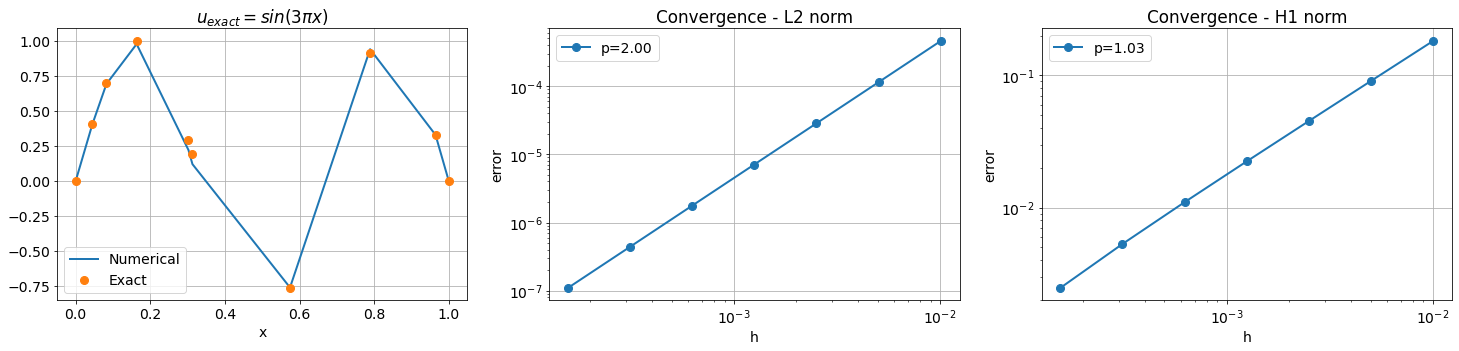

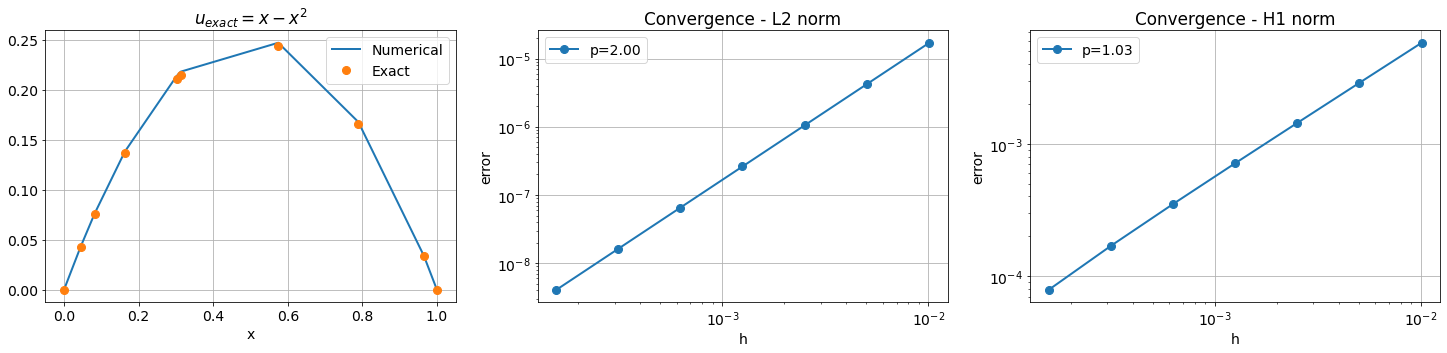

In [162]:
H_L2, E_L2, p_L2 = convergence(7, 100, f_2, u_exact_2, norm = L2)
H_H1, E_H1, p_H1 = convergence(7, 100, f_2, u_exact_2, norm = H1)

H2_L2, E2_L2, p2_L2 = convergence(7, 100, f_1, u_exact_1, norm = L2)
H2_H1, E2_H1, p2_H1 = convergence(7, 100, f_1, u_exact_1, norm = H1)

plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plot_solution(Xk, U2, u_exact_2)
plt.title("$u_{exact} = sin(3 \pi x)$")
            
plt.subplot(1,3,2)
plt.title("Convergence - L2 norm")
plt.loglog(H_L2,E_L2,'o-', label='p={:.2f}'.format(p_L2))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();


plt.subplot(1,3,3)
plt.title("Convergence - H1 norm")
plt.loglog(H_H1, E_H1, 'o-', label='p={:.2f}'.format(p_H1))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()
plt.show()


plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plt.title("$u_{exact} = x-x^2$")
plot_solution(Xk, U1, u_exact_1)

plt.subplot(1,3,2)
plt.title("Convergence - L2 norm")
plt.loglog(H2_L2,E2_L2,'o-', label='p={:.2f}'.format(p2_L2))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();


plt.subplot(1,3,3)
plt.title("Convergence - H1 norm")
plt.loglog(H2_H1, E2_H1, 'o-', label='p={:.2f}'.format(p2_H1))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()
plt.show()

## Exercise d: Non-smooth potential exact solutions

Now we solve for the function
$$w_1 = $$

In [163]:
def fv_w1_right_up(x, xi, hi):
    #alpha wx vx + b wx v + cwv
    v = (x-xi)/hi
    vx = 1/hi
    
    wx = -2 
    w = 2*(1-x)
    
    return alpha * wx * vx + b * wx * v + c * w * v

def fv_w1_right_down(x, xi, hi):
    #alpha wx vx + b wx v + cwv
    v = (xi - x)/hi
    vx = -1/hi
    
    wx = -2 
    w = 2*(1-x)
    
    return alpha * wx * vx + b * wx * v + c * w * v

def fv_w1_left_up(x, xi, hi):
    #alpha wx vx + b wx v + cwv
    v = (x-xi)/hi
    vx = 1/hi
    
    wx = 2
    w = 2*x
    
    return alpha * wx * vx + b * wx * v + c * w * v

def fv_w1_left_down(x, xi, hi):
    #alpha wx vx + b wx v + cwv
    v = (xi - x)/hi
    vx = -1/hi
    
    wx = 2 
    w = 2*x
    
    return alpha * wx * vx + b * wx * v + c * w * v

def w1_exact(x):
    
    w2 = 2*(1-x[x >= 1/2])
    w1 = 2* x[x < 1/2]
    
    return np.concatenate((w1, w2))


In [164]:
def create_F_nonsmooth1(X, Mi, H, x_singular, f_func_left_up, f_func_left_down, f_func_right_up, f_func_right_down):
    '''input:
    f_function 
    X: array of size Mi, x-axis points
    H: array of size Mi, step sizes'''
    F = np.zeros(Mi)
    tol = 1e-6
    for i in range(len(H)):
        if X[i] == x_singular:
            X[i] -= tol
        '''
        if X[i] == x_singular:         #phi function is split on singularity point
            print(X[i])
            first_int = integrate.quad(lambda x: f_func_left_up(x, X[i-1], H[i-1]), X[i-1], x_singular)[0]       #integrating from x_i-1 to xi
            second_int = integrate.quad(lambda x: f_func_right_down(x, X[i+1], H[i]), x_singular, X[i+1])[0]       #integrating from xi to xi+1
        ''' 

        if X[i + 1] < x_singular:   #entire phi function is on left side of singularity
            first_int = integrate.quad(lambda x: f_func_left_up(x, X[i-1], H[i-1]), X[i-1], X[i])[0]       #integrating from x_i-1 to xi
            second_int = integrate.quad(lambda x: f_func_left_down(x, X[i+1], H[i]), X[i], X[i+1])[0]    #integrating from xi to xi+1
        
        elif X[i -1] > x_singular:    #entire phi function is on right side of singularity
            first_int = integrate.quad(lambda x: f_func_right_up(x, X[i-1], H[i-1]), X[i-1], X[i])[0]       #integrating from x_i-1 to xi
            second_int = integrate.quad(lambda x: f_func_right_down(x, X[i+1], H[i]), X[i], X[i+1])[0]    #integrating from xi to xi+1
        
            
        elif X[i+1] > x_singular and X[i] < x_singular:  #part of phi_down is on left side of singularity and half is on right side of singularity
            #print('nå har den gått inn her', X[i])
            first_int = integrate.quad(lambda x: f_func_left_up(x, X[i-1], H[i-1]), X[i-1], X[i])[0]       #integrating from x_i-1 to xi
            
            second_int += integrate.quad(lambda x: f_func_left_down(x, X[i+1], H[i]), X[i], x_singular)[0]    #integrating from xi to xi+1
            second_int += integrate.quad(lambda x: f_func_right_down(x, X[i+1], H[i]), x_singular, X[i+1])[0]    #integrating from xi to xi+1
        
        elif X[i-1] < x_singular and X[i] > x_singular:  #part of phi_up is on left side of singularity and half is on right side of singularity
            #print('nå har den gått inn der', X[i])
            first_int += integrate.quad(lambda x: f_func_left_up(x, X[i-1], H[i-1]), X[i-1], x_singular)[0]       #integrating from x_i-1 to xi
            first_int += integrate.quad(lambda x: f_func_right_up(x, X[i-1], H[i-1]), x_singular, X[i])[0]       #integrating from x_i-1 to xi

            second_int = integrate.quad(lambda x: f_func_right_down(x, X[i+1], H[i]), X[i], X[i+1])[0]    #integrating from xi to xi+1
        
        
        F[i] = first_int + second_int
            

    return F

Now, solve for

$$w_2 = x - \vert x\vert^{\frac{2}{3}} $$

In [165]:
def w2_exact(x):
    w1 = x[x< 0] - (-x[x< 0])**(2/3)
    w2 = x[x>= 0]-x[x>= 0]**(2/3)
    return np.concatenate((w1, w2))

def fv_w2_up(x, xi, hi):
    #alpha wx vx + b wx v + cwv
    v = (x-xi)/hi
    vx = 1/hi
    
    wx = 1 - 2/3*x**(-1/3)
    w = x-x**(2/3)
    
    return alpha * wx * vx + b * wx * v + c * w * v

def fv_w2_down(x, xi, hi):
    #alpha wx vx + b wx v + cwv
    v = (xi - x)/hi
    vx = -1/hi
    
    wx = 1-2/3*x**(-1/3)
    w = x-x**(2/3)
    
    return alpha * wx * vx + b * wx * v + c * w * v

In [166]:
#Creating F inside solver
def solver_FEM_nonsmooth2(X, f_func_up, f_func_down):
    Mi = len(X)                     #Number of nodes
    T = np.ndarray.transpose(np.array([X[:-1],X[1:]])) # Set of elements/triangulation
    H = X[1:]-X[:-1]               #Element sizes
    Mk = Mi-1                        #Number of elements
    
    #tol = 1e-3
    
    F = np.zeros(Mi)
    for i in range(1, len(H)-1):
        
        first_int = integrate.quad(lambda x: f_func_up(x, X[i-1], H[i-1]), X[i-1], X[i])[0]       #integrating from x_i-1 to xi
        second_int = integrate.quad(lambda x: f_func_down(x, X[i+1], H[i]), X[i], X[i+1])[0]    #integrating from xi to xi+
        
        F[i] = first_int + second_int
    A = create_A(X, Mi, T, H, Mk)
    
    #solving for inner points:
    U_inner = np.linalg.solve(A[1:-1, 1:-1],F[1:-1])
    
    #Combining with boundary conditions u0 = 0 = u1
    U_total = np.zeros(len(U_inner)+2)
    U_total[1:-1] = U_inner
    
    return U_total

Convergence:

In [167]:
def convergence_d1(P, M0, fv_w2_up, w1_exact, norm = L2):
    Mi = M0

    Hconv = np.zeros(P)
    Econv = np.zeros(P)

    for p in range(P):
        x = np.linspace(0,1, Mi)
        W = solver_FEM(x, fv_w2_up, create_F_nonsmooth1, new_solver = True)
        exact = w1_exact(x)
        Eh = exact-W

        Hconv[p] = (x[1]-x[0])
        Econv[p] = norm(Eh, x) #sqrt(h) since we shift from vector norm l2 to L2
            
        Mi = 2*Mi+1

    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

def convergence_d2(P, M0, fv_w2_up, fv_w2_down, w2_exact, norm = L2):
    Mi = M0

    Hconv = np.zeros(P)
    Econv = np.zeros(P)

    for p in range(P):
        x = np.linspace(0,1, Mi)
        U = solver_FEM_nonsmooth2(x, fv_w2_up, fv_w2_down)
        exact = w2_exact(x)
        Eh = exact-U

        Hconv[p] = (x[1]-x[0])
        Econv[p] = norm(Eh, x) #sqrt(h) since we shift from vector norm l2 to L2
            
        Mi = 2*Mi

    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order




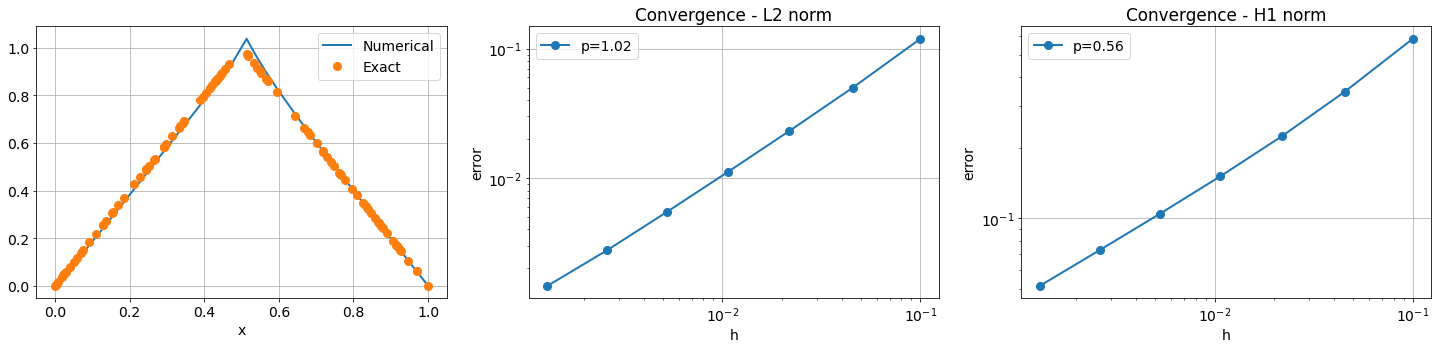

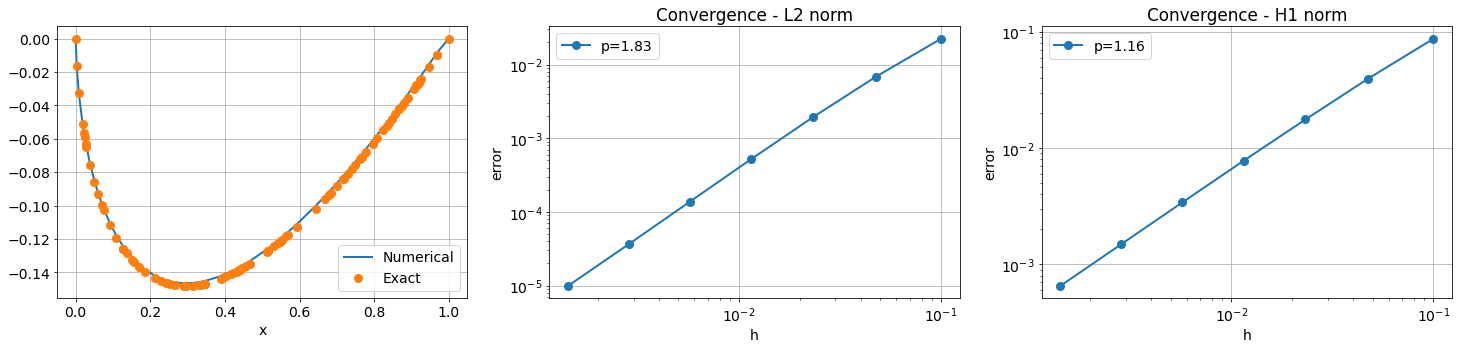

In [168]:
M = 100
x = create_x(M)[1]

W_1 = solver_FEM(x, fv_w2_up, create_F_nonsmooth1, new_solver = True)
H_d1, E_d1, p_d1 = convergence_d1(7, 11, fv_w2_up, w1_exact, norm = L2)
H_d2, E_d2, p_d2 = convergence_d1(7, 11, fv_w2_up, w1_exact, norm = H1)


plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plot_solution(x, W_1, w1_exact)

plt.subplot(1,3,2)
plt.loglog(H_d1,E_d1,'o-', label='p={:.2f}'.format(p_d1))
plt.title("Convergence - L2 norm")
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();

plt.subplot(1,3,3)
plt.loglog(H_d2,E_d2,'o-', label='p={:.2f}'.format(p_d2))
plt.title("Convergence - H1 norm")
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();
plt.show()



W_2 = solver_FEM_nonsmooth2(x, fv_w2_up, fv_w2_down)
H_d3, E_d3, p_d3 = convergence_d2(7, 11, fv_w2_up, fv_w2_down, w2_exact, norm = L2)
H_d4, E_d4, p_d4 = convergence_d2(7, 11, fv_w2_up, fv_w2_down, w2_exact, norm = H1)

plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plot_solution(x, W_2, w2_exact)

plt.subplot(1,3,2)
plt.loglog(H_d3,E_d3,'o-', label='p={:.2f}'.format(p_d3))
plt.title("Convergence - L2 norm")
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();

plt.subplot(1,3,3)
plt.loglog(H_d4,E_d4,'o-', label='p={:.2f}'.format(p_d4))
plt.title("Convergence - H1 norm")
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();
plt.show()

# e

$$ f(x) = x^{-\frac{1}{4}}, x \in (0, 1)$$

In [144]:
b = -15


In [145]:
def plot_solution_2e(X, U, x_refined, u_refined):
    plt.plot(X, U,'o')
    plt.plot(x_refined, u_refined,'-')
    plt.legend(['Numerical','Refined'])
    plt.xlabel('x');

In [146]:
def f_e(x):
    return x**(-1/4)

def u_e_exact(x):
    return 0.5*x

def create_x_2e(M): #more points around x = 0.
    M_inner = M - 2
    M_temp = int(2/3 * M_inner)
    num_pts_left = int(M/2)

    # x_1 = rd.uniform(low=0.0, high=0.2, size=M_temp)
    # x_2 = rd.uniform(low=0.2, high=1, size=M_inner-M_temp+1)
    x_1 = np.linspace(0,0.15, num_pts_left, endpoint=False)
    x_2 = np.linspace(.15,1, M-num_pts_left)


    x_bc = np.array([1])
    X = np.sort(np.concatenate((x_1, x_2)))

    ''' 
    x_1 = np.linspace(0,0.2, M//2)
    x_2 = np.linspace(0.2,1, M//2)
    '''

    return M, X

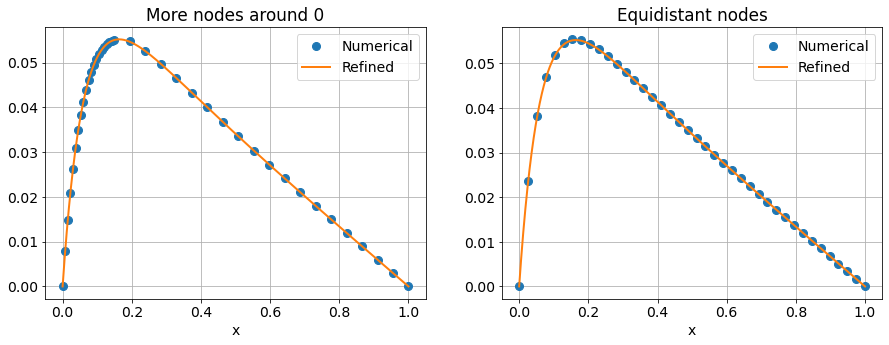

In [148]:
M_2e = 40
x_equidist = np.linspace(0,1,M_2e)
x_irreg = create_x_2e(M_2e)[1]

U_irreg = solver_FEM(x_irreg, f_e)
U_equisit = solver_FEM(x_equidist, f_e)

M_refined = 10000
x_refined = np.linspace(0, 1, M_refined, endpoint = "True")
U_refined = solver_FEM(x_refined, f_e)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("More nodes around 0")
plot_solution_2e(x_irreg, U_irreg, x_refined, U_refined)

plt.subplot(1,2,2)
plot_solution_2e(x_equidist, U_equisit, x_refined, U_refined)
plt.title("Equidistant nodes")

plt.show()

In [149]:
def convergence_e(P, M0, u_refined, x_refined, irreg_nodes = True, norm = L2):
    Mi = M0

    Mconv = np.zeros(P)
    Econv = np.zeros(P)
    U_interpolate = interpolate.interp1d(x_refined, u_refined)

    if irreg_nodes == True:
        for p in range(P):
            x = create_x_2e(Mi)[1]
            U = solver_FEM(x, f_e)
            Eh = U - U_interpolate(x)

            Mconv[p] = Mi
            Econv[p] = norm(Eh, x) 
                
            Mi = 2*Mi

    else:
        for p in range(P):
            x = np.linspace(0,1, Mi)
            U = solver_FEM(x, f_e)
            Eh = U - U_interpolate(x)

            Mconv[p] = Mi
            Econv[p] = norm(Eh, x) 
                    
            Mi = 2*Mi

    order = np.polyfit(np.log(Mconv),np.log(Econv),1)[0]
    return Mconv, Econv, order

In [150]:
M_irreg, E_irreg, p_irreg = convergence_e(7, 100, U_refined, x_refined, norm = H1)

M_equidist, E_equidist, p_equidist = convergence_e(7, 100, U_refined, x_refined, irreg_nodes=False, norm = H1)

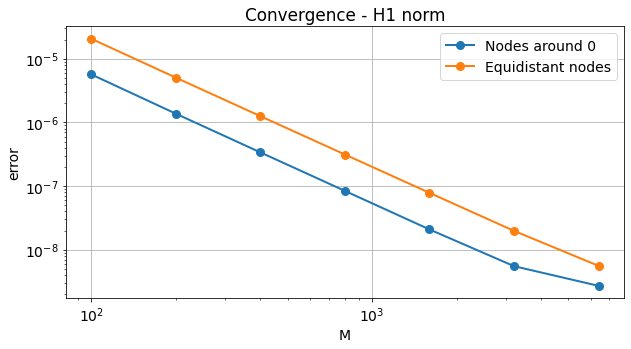

In [151]:
plt.figure(figsize=(10,5))
plt.loglog(M_irreg,E_irreg,'o-', label='Nodes around 0')
plt.loglog(M_equidist,E_equidist,'o-', label='Equidistant nodes')
plt.title("Convergence - H1 norm")
plt.grid('on')
plt.xlabel('M')
plt.ylabel('error')
plt.legend();